In [1012]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Introduction ✨

Problem statement : predicting survival prediction based on the given dimension

In [1013]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


In [1014]:
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
test = pd.read_csv("../input/titanic/test.csv")
train = pd.read_csv("../input/titanic/train.csv")
train.info() # Rough estimating the missing values for test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1015]:
test.info() # Rough estimating the missing values for train
test_original = test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [1016]:
train.head(10) # Survival is given and we need to predict it for the test set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [1017]:
test.head(10) 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


# EDA (Exploratory Data Analysis)

### Missing values

missing values in training set and there respective percentage

In [1018]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


# Understanding the data

* Train samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
* Survived is a categorical feature with 0 or 1 values.
* Around 38% samples survived representative of the actual survival rate at 32%.
* Most passengers (> 75%) did not travel with parents or children.
* Nearly 30% of the passengers had siblings and/or spouse aboard.
* Fares varied significantly with few passengers (<1%) paying as high as  512.
* Few elderly passengers (<1 percent) within age range 65-80.
* Names are unique across the dataset (count=unique=891)
* Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
* Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [1019]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1020]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",male,347082,B96 B98,S
freq,1,577,7,4,644


## Feature Engineering

pclass   = Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

sex      = Sex	
Age      = Age (years)	
sibsp    = number of siblings / spouses aboard the Titanic	
parch    = number of parents / children aboard the Titanic	
ticket   = Ticket number	
fare     = Passenger fare	
cabin    = Cabin number	
embarked = Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton) 
 
survival = Survival	(0 = No, 1 = Yes)

## 1. Pclass 

In [1021]:
Pclass_analyze = train[['Survived','Pclass']].groupby(['Pclass'],as_index = False).mean() # Pclass have no missing values (Total count 891 in train and 418 in test)
print(Pclass_analyze) 
# Ratio gives us the probability for the survival (for example for Pclass 1 the survived probability in 0.629 and the death probability is 0.371)

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


## 2.Sex 

In [1022]:
Sex_analyze = train[['Sex','Survived']].groupby(('Sex'),as_index = False).mean() # Sex have no missing values (Total count 891 in train and 418 in test)
print(Sex_analyze)

      Sex  Survived
0  female  0.742038
1    male  0.188908


## 3. SibSp and Parch

With the number of siblings/spouse and the number of children/parents we can create new feature called Family Size.

In [1023]:
data = [train,test] # create a new array
for d in data:
    d['Family'] = d['SibSp']+d['Parch']  # combining sibling and spouse as a new parameter Family  
    Family_analyze = train[['Family','Survived']].groupby(['Family'],as_index=False).mean()
print(Family_analyze)

   Family  Survived
0       0  0.303538
1       1  0.552795
2       2  0.578431
3       3  0.724138
4       4  0.200000
5       5  0.136364
6       6  0.333333
7       7  0.000000
8      10  0.000000


Probability of being alone and with family survival rate

In [1024]:
for d in data:
    d['IsAlone'] = 0
    d.loc[d['Family'] == 0, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

# Where  1 = alone and 0 = with family

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


## 4. Embarked

In [1025]:
train['Embarked'].isnull().sum()

2

In [1026]:
train['Embarked'].mode()

0    S
dtype: object

In [1027]:
train['Embarked'] = train['Embarked'].fillna('S') # filling the 2 missing values with mode i.e S=Southampton
print(train[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


## 5. Cabin

As every cabin has unique id and 77 percent values are missing so this sort coulmn in useless for survival prediction but still to improve accuracy(at some extent) we will include it

In [1028]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
print(train[['Has_Cabin','Survived']].groupby(['Has_Cabin'],as_index=False).mean())

   Has_Cabin  Survived
0          0  0.299854
1          1  0.666667


## 6. Fare

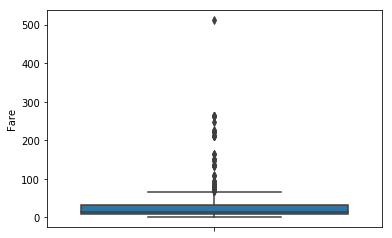

In [1029]:
sns.boxplot( y=d['Fare'] );
plt.show()

In [1030]:
test.isnull().sum() # as there is one missing value in fare in the test data set so we need to fill it
test['Fare'] = test['Fare'].fillna(test['Fare'].median()) # as we can see much outliers in the fare so fill th emissing value with median
test['Fare']

0        7.8292
1        7.0000
2        9.6875
3        8.6625
4       12.2875
         ...   
413      8.0500
414    108.9000
415      7.2500
416      8.0500
417     22.3583
Name: Fare, Length: 418, dtype: float64

In [1031]:
train['CategoricalFare'] = pd.qcut(train['Fare'], 3) # We quartiled the fare data into 3 section as the lowest medium and higher
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0  (-0.001, 8.662]  0.198052
1    (8.662, 26.0]  0.402778
2  (26.0, 512.329]  0.559322


## 7. Age

we have plenty of missing values in this feature. # generate random numbers between (mean - std) and (mean + std). then we categorize age into 5 range.

In [1032]:
for d in data:
    avg_mean = d['Age'].mean()   # taking mean
    avg_std = d['Age'].std()     # taking std
    # the standard deviation is a measure of the amount of variation or dispersion of a set of values
    
    avg_null_count = d['Age'].isnull().sum()   #total null count that is 177
    
    age_fill_null = np.random.randint(avg_mean-avg_std,avg_mean+avg_std, size=avg_null_count) # generating random age between max and min number with the size of total number generated are 177
    
    
    #if d['Age'].isnan:
    #   d['Age'] = avg_null_count # if the value of age is null fill it withn the avg value 
    
    d['Age'][np.isnan(d['Age'])] = age_fill_null # # replacing the nan values with the random generated age avg value 
    d['Age'] = d['Age'].astype(int) 

train['AgeSlots'] = pd.cut(train['Age'],5) # making another categorical label with cutting age into 5 age-slots 

# pd.cut :
# Use cut when you need to segment and sort data values into bins.
# This function is also useful for going from a continuous variable to a categorical variable.
# For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.


print(train[['AgeSlots','Survived']].groupby(['AgeSlots'],as_index = False).mean())

        AgeSlots  Survived
0  (-0.08, 16.0]  0.522124
1   (16.0, 32.0]  0.347727
2   (32.0, 48.0]  0.383721
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 8. Name

In [1033]:
train['Name']  # As each name is unique so we cant get much out of it but what if we use the Title (i.e Mr,Mrs,Miss etc) 

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [1034]:
def title(name):
    title_search = re.search('([A-Za-z]+)\.',name)   # word:=Any combination of letters both upper case or lower case
    
    if title_search:
        return title_search.group(1)  # return the second element of the group (i.e from Braund, "Mr. Owen Harris" return " Mr. ")
    return 

In [1035]:
for d in data:
    d['Title'] = d['Name'].apply(title) # creating a new coulumn name 'Title' and storing the title in it
    
print(pd.crosstab(train['Title'],train['Sex']))      # Crosstab : Compute a simple cross tabulation of two (or more) factors.


Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [1036]:
for d in data:
    d['Title']  = d['Title'].replace(['Capt','Col','Countess','Don','Dr','Jonkheer','Lady','Major','Rev','Sir'],'Other')
    
    d['Title'] = d['Title'].replace('Mlle', 'Miss')
    d['Title'] = d['Title'].replace('Ms', 'Miss')
    d['Title'] = d['Title'].replace('Mme', 'Mrs')
       
print(train[['Title','Survived']].groupby(['Title'],as_index = False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4   Other  0.347826


# Data Cleaning

converting our features into numerical values

In [1037]:
for d in data:
    
    # SEX
    d['Sex'] = d['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Title (Name)
    apply_map = { 'Mr': 1, 'Miss': 2, 'Mrs' : 3, 'Master': 4, 'Other': 5 } 
    d['Title'] = d['Title'].map(apply_map)
    d['Title'] = d['Title'].fillna(0)
   
    # Embarked
    d['Embarked'] = d['Embarked'].map({ 'C': 1, 'S': 2, 'Q': 3 }).astype(int)
    
    # FareSlots (Fare)
    d.loc[d['Fare'] <= 8.662,'Fare'] = 0                        # lowest Fare
    d.loc[(d['Fare'] > 8.662) & (d['Fare']<= 26.0) ,'Fare'] = 1   # medium Fare
    d.loc[(d['Fare'] > 26.0),'Fare'] = 2                          # highest Fare
    
    # AgeSLots (Age)
    d.loc[d['Age'] <= 16.0 ,'Age'] = 0
    d.loc[(d['Age'] > 16.0)  &  (d['Age'] <= 32.0) , 'Age' ] = 1
    d.loc[(d['Age'] > 32.0)  &  (d['Age'] <= 48.0) , 'Age' ] = 2
    d.loc[(d['Age'] > 48.0)  &  (d['Age'] <= 64.0) , 'Age' ] = 3
    d.loc[(d['Age'] > 64.0),'Age'] = 4
    

In [1038]:
d['Sex'] = d['Sex'].astype(int)
d['Title'] = d['Title'].astype(int)
d['Embarked'] = d['Embarked'].astype(int)
d['Age'] = d['Age'].astype(int)
d['Fare'] = d['Fare'].astype(int)
d['IsAlone'] = d['IsAlone'].astype(int)
d['Has_Cabin'] = d['Has_Cabin'].astype(int)

In [1039]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,IsAlone,Has_Cabin,CategoricalFare,AgeSlots,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0.0,NaN,2,1,0,0,"(-0.001, 8.662]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,2.0,C85,1,1,0,1,"(26.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,0.0,NaN,2,0,1,0,"(-0.001, 8.662]","(16.0, 32.0]",2


# Feature Selection

-dropping the irrelevant features

In [1040]:
drop_elements = ['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'] # dropping the irrevant features from train and test data set
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalFare','AgeSlots'], axis = 1)  # droping the slotted features from training set only

In [1041]:
train['Fare'] = train['Fare'].astype(int)
test['Fare'] = test['Fare'].astype(int)
train.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Family,IsAlone,Has_Cabin,Title
0,0,3,1,1,0,2,1,0,0,1
1,1,1,0,2,2,1,1,0,1,3
2,1,3,0,1,0,2,0,1,0,2
3,1,1,0,2,2,2,1,0,1,3
4,0,3,1,2,0,2,0,1,0,1


-from dataframe to an array row wise

In [1042]:
train.values #returns a view object that displays a list of all the values in the dictionary.
test.values

array([[3, 1, 2, ..., 1, 0, 1],
       [3, 0, 2, ..., 0, 0, 3],
       [2, 1, 3, ..., 1, 0, 1],
       ...,
       [3, 1, 2, ..., 1, 0, 1],
       [3, 1, 1, ..., 1, 0, 1],
       [3, 1, 1, ..., 0, 0, 4]])

# Analyze By Visualizing Data

## Correlation

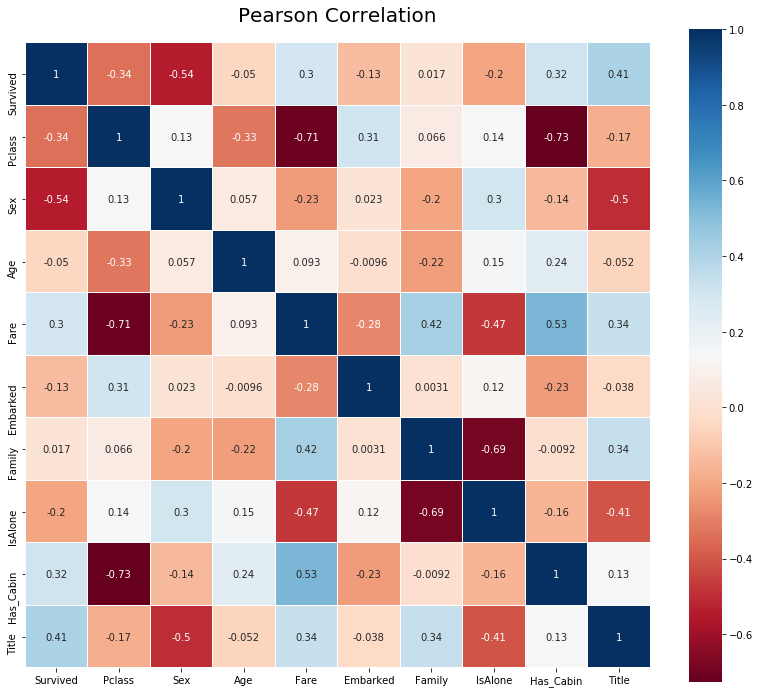

In [1043]:
colormap = plt.cm.RdBu  # declaring the color pattern (mentioned as in : https://matplotlib.org/examples/color/colormaps_reference.html)
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation', y=1.025, size=20)  # 'y' is position of title (where zero is centre of the image)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


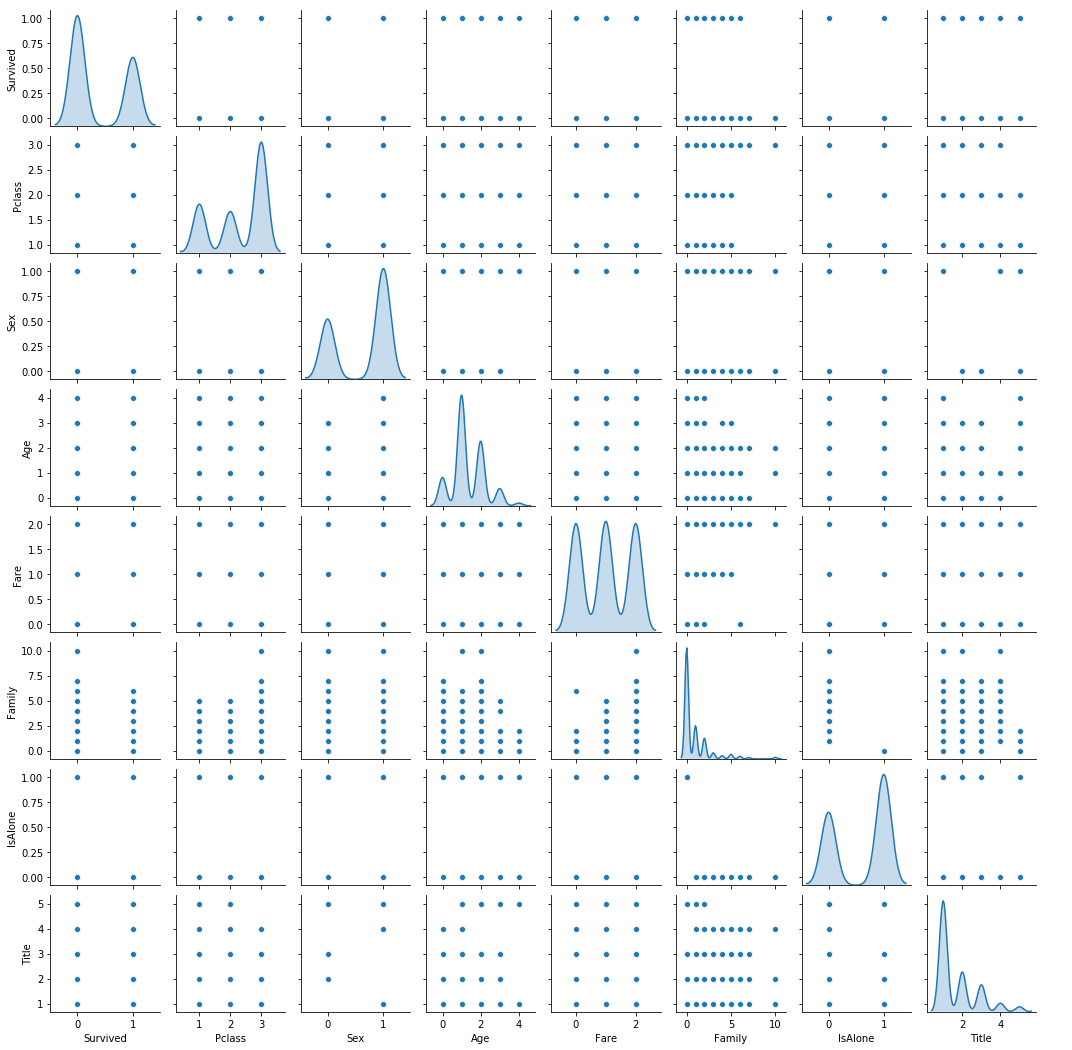

In [1044]:
g = sns.pairplot(train[['Survived','Pclass','Sex','Age','Fare','Family','IsAlone','Title']],size=1.8,diag_kind = 'kde')

## Embarked

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


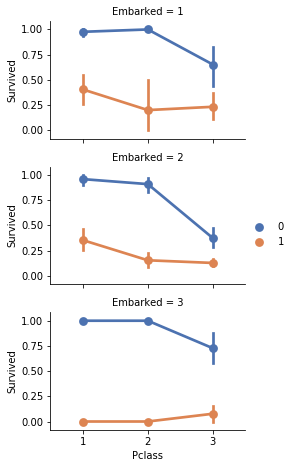

In [1045]:
grid = sns.FacetGrid(train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## Cabin

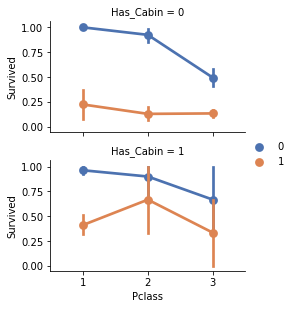

In [1046]:
grid = sns.FacetGrid(train, row='Has_Cabin', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## Further Exploring Features

0  =  0 to 16
1  =  16 to 32
2  =  32 to 48
3  =  48 to 64
4  =  64 to 80


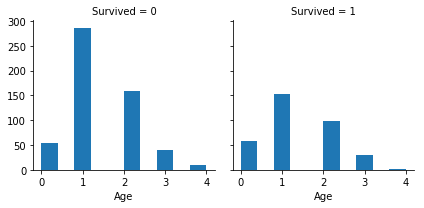

In [1047]:
g = sns.FacetGrid(train, col='Survived')   # mapping the dataset onto multiple axes arrayed in a grid of rows and columns that correspond to levels of variables in the dataset
g = g.map(plt.hist , 'Age')

print('0 ' + ' = '  ' 0 to 16') 
print('1 ' + ' = ' ' 16 to 32')
print('2 ' + ' = ' ' 32 to 48')
print('3 ' + ' = ' ' 48 to 64')
print('4 ' + ' = ' ' 64 to 80')

Observations.

* Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption.
* Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption. 
* Most passengers in Pclass=1 survived. Confirms our classifying assumption.
* Pclass varies in terms of Age distribution of passengers.

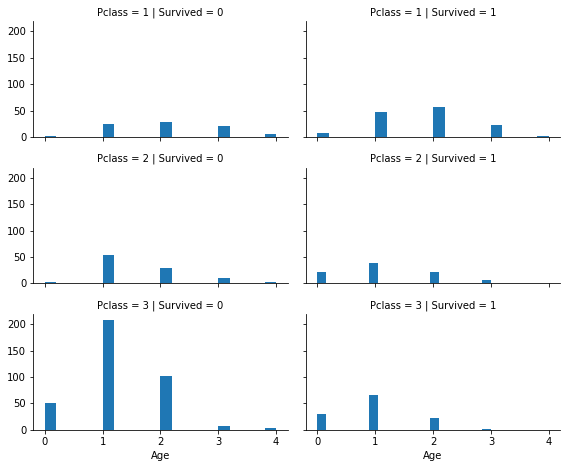

In [1048]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2.2, aspect=1.8)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend();

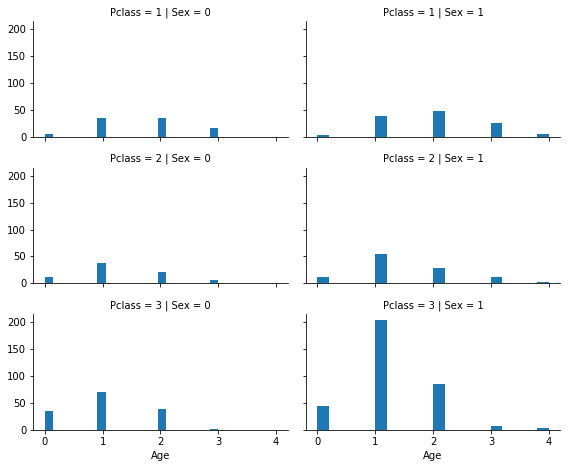

In [1049]:
grid = sns.FacetGrid(train, row='Pclass', col='Sex', size=2.2, aspect=1.8)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()

# Modeling and Comparing

Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:
* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest
* Perceptron
* Artificial neural network
* RVM or Relevance Vector Machine

In [1050]:
X_train = train.drop(['Survived'],axis=1)
Y_train = train['Survived']
print(X_train.shape,Y_train.shape)

(891, 9) (891,)


In [1051]:
test.head(5)

,Pclass,Sex,Age,Fare,Embarked,Family,IsAlone,Has_Cabin,Title
0,3,1,2,0,3,0,1,0,1
1,3,0,2,0,2,1,0,0,3
2,2,1,3,1,3,0,1,0,1
3,3,1,1,1,2,0,1,0,1
4,3,0,1,1,2,2,0,0,3


In [1052]:
X_test = test

## Logistic Regression

In [1053]:
LR = LogisticRegression()
LR.fit(X_train,Y_train)
LR_Y_Pred = LR.predict(X_test)
score_lr = round(LR.score(X_train,Y_train)*100,2)
score_lr

80.81

## KNN or k-Nearest Neighbors

In [1054]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
knn_Y_Pred = knn.predict(X_test)
score_knn = round(knn.score(X_train,Y_train)*100,2)
score_knn

85.86

## Support Vector Machine

In [1055]:
SVC = SVC()
SVC.fit(X_train,Y_train)
SVC_Y_Pred = SVC.predict(X_test)
score_svc = round(SVC.score(X_train,Y_train)*100,2)
score_svc

83.73

## Gaussian Naive Bayes

In [1056]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
score_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
score_gaussian

78.0

## Perceptron

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time.

In [1057]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
score_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
score_perceptron

76.21

## Linear SVC

In [1058]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
score_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
score_linear_svc

/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


81.59

## Stochastic Gradient Descent

In [1059]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
score_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
score_sgd

80.25

## Decision Tree

In [1060]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
score_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
score_decision_tree

88.44

## Random Forest

In [1061]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_RF = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
score_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
score_random_forest

88.44

## Evaluating The Models

In [1062]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [score_svc, score_knn, score_lr, 
              score_random_forest, score_gaussian, score_perceptron, 
              score_sgd, score_linear_svc, score_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,88.44
8,Decision Tree,88.44
1,KNN,85.86
0,Support Vector Machines,83.73
7,Linear SVC,81.59
2,Logistic Regression,80.81
6,Stochastic Gradient Decent,80.25
4,Naive Bayes,78.00
5,Perceptron,76.21


### Submission

In [1063]:
submission = pd.DataFrame({
        "PassengerId": test_original["PassengerId"],
        "Survived": Y_pred_RF
    })
submission.to_csv("Submission.csv", index=False)

In [1064]:
print(submission)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


# Our prediction accuracy is 75.119%

# To improve further accuracy we need to apply KFolds or some boosting classifiers